In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import seaborn as sns
import anndata
from scipy.sparse import csr_matrix


plt.rcParams['pdf.fonttype'] = 42 #for saving PDF with changeable text
plt.rcParams['ps.fonttype'] = 42 #for saving PDF with changeable text

# my code
%load_ext autoreload
%autoreload 2
from passenger.plot.plot import *


/home/vmarotl/anaconda3/envs/passenger/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
patient = "P1"
anon_adata = anndata.read_h5ad("/home/vmarotl/fast/mutaseq/scripts/clonal_tracing_notebooks/processed_data_anonymised//AML_MutaSeq/"+patient+".h5ad")
adata = anndata.read_h5ad("/home/vmarotl/fast/mutaseq/scripts/clonal_tracing_notebooks/processed_data//AML_MutaSeq/"+patient+".h5ad")



In [3]:
# let's get the preleukemic variants for compariosn

# the mitochondrial variants
mito_vars_preleuk = ["X11559GA","X7527GDEL"#, "X1282GA"
                    ]

mito_MUT = pd.read_csv("../ref_data/AML_MutaSeq/P1/P1_mut.csv", index_col=0).T[mito_vars_preleuk].loc[adata.obs_names]
mito_REF = pd.read_csv("../ref_data/AML_MutaSeq/P1/P1_ref.csv", index_col=0).T[mito_vars_preleuk].loc[adata.obs_names]
preleuk_COV = mito_MUT+mito_REF
preleuk_VAF = mito_MUT/preleuk_COV

# the nuclear ones
nuclear_vars_preleuk = {"SRSF2":"76736877", "EAPP":"34516407"}
for i in nuclear_vars_preleuk.keys():
    preleuk_COV[i]=adata[:,adata.var.pos == nuclear_vars_preleuk[i]].X[:,0].tolist()
    preleuk_VAF[i]=adata[:,adata.var.pos == nuclear_vars_preleuk[i]].layers["ALT"][:,0].tolist()/preleuk_COV[i]
preleuk_VAF[preleuk_COV<2]=np.nan

In [4]:
# ordering of cells for ease of comparison

C = adata.obsm["C"]
ref = adata.obsm["ref_assignments"][ ['PhiSICShealthy',
       'PhiSICSpreleukemic', 'PhiSICScancer', 'PhiSICScancerC2']]
sub_cells =np.abs(C[:,0]-C[:,1])>.3

C1 = ((C[:,0]>.5)*(ref>.5).T).T
C2 = ((C[:,1]>.5)*(ref>.5).T).T

row_ind = pd.concat((C1, C2, 1-preleuk_VAF["X11559GA"]>0.05), axis=1).loc[sub_cells]
row_ind.columns = np.arange(0, row_ind.shape[1])
row_ind = row_ind.sort_values(row_ind.columns.tolist(),ascending=True).index 

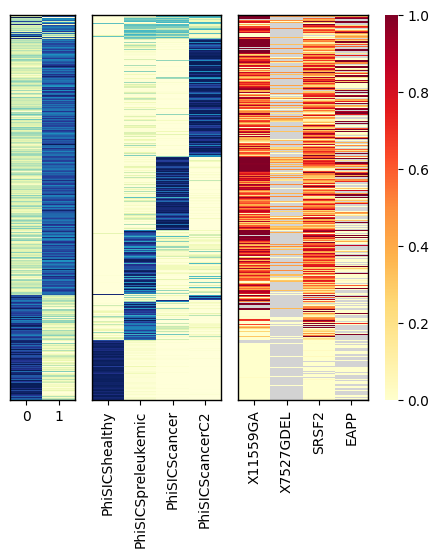

In [5]:
f,(axs) = plt.subplots(1,4,#3, 
            gridspec_kw={'width_ratios':[.5,1, 1,0.1]}, figsize=(5,5))

args = {"cmap":cell_cmap, "cbar_ax":axs[-1], "yticklabels":[], "vmin":0, "vmax":1}

g0 = sns.heatmap(adata[row_ind].obsm["C"], ax=axs[0],  **args)
set_border(g0)

g1 = sns.heatmap(ref.loc[row_ind], ax=axs[1], **args ,
                #xticklabels = ["Healthy", "Preleukemic", "Cancer clone 1", "Cancer clone 2"]
                )
set_border(g1)

g2 = sns.heatmap(preleuk_VAF.loc[row_ind], ax=axs[2], yticklabels=[], cbar_ax=axs[-1],
                 cmap=var_cmap)
set_border(g2)

plt.savefig("../figures/Fig2_P1-preleuk.pdf", bbox_inches='tight', format='pdf', dpi=300)
plt.show()
plt.close()

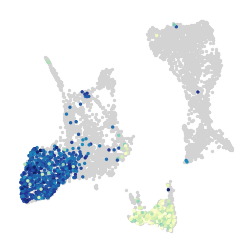

In [6]:
umap_all = pd.read_csv("../ref_data/AML_MutaSeq//umap_all.csv")

fig, ax = plt.subplots(1,1, figsize=(3, 3))

plt.scatter(umap_all.UMAP_1, umap_all.UMAP_2, color="lightgrey", s=2)
plt.scatter(adata[row_ind].obsm["umap"].UMAP_1, adata[row_ind].obsm["umap"].UMAP_2,
            c=adata[row_ind].obsm["C"][:,1], cmap=cell_cmap, s=2)

ax.axis('off')
save_path = "../figures/Fig2_P1-umap.png"
fig.savefig(save_path, bbox_inches='tight', format='png', dpi=300)

plt.show()

In [7]:
C = adata.obsm["C"]
sub_cells =np.abs(C[:,0]-C[:,1])>.3

sort_by = pd.DataFrame(adata.obsm["C"], index = adata.obs_names).loc[sub_cells]
row_ind = sort_by.sort_values([0],ascending=False).index # sort by know assignments
adata = adata[row_ind]

# define some helper for simplicity in plotting
VAF = (adata.layers["ALT"]/(adata.X))
VAF[adata.X<=2]=np.nan
V = adata.varm["V"]

clones = np.argmax(adata.obsm["C"], axis=1)
expressed = np.any(V>=0, axis=1)
for i in np.unique(clones): # only variants covered in both clones
    expressed &= np.sum(adata[(clones==i)].X>=2, axis=0)>(.2*np.sum((clones==i)))

WE_cov = np.array([adata.var.cancer_cov,
                        adata.var.healthy_cov]
                        )
WE_VAF = (np.array([adata.var.cancer_alt,
                        adata.var.healthy_alt]
                        )/WE_cov).T
WE_VAF[WE_cov.T<=10]=np.nan

/home/vmarotl/anaconda3/envs/passenger/lib/python3.10/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in divide
  results = super().__array_ufunc__(
/tmp/7178635.1.all.q/ipykernel_18887/2612724626.py:21: RuntimeWarning: invalid value encountered in divide
  WE_VAF = (np.array([adata.var.cancer_alt,


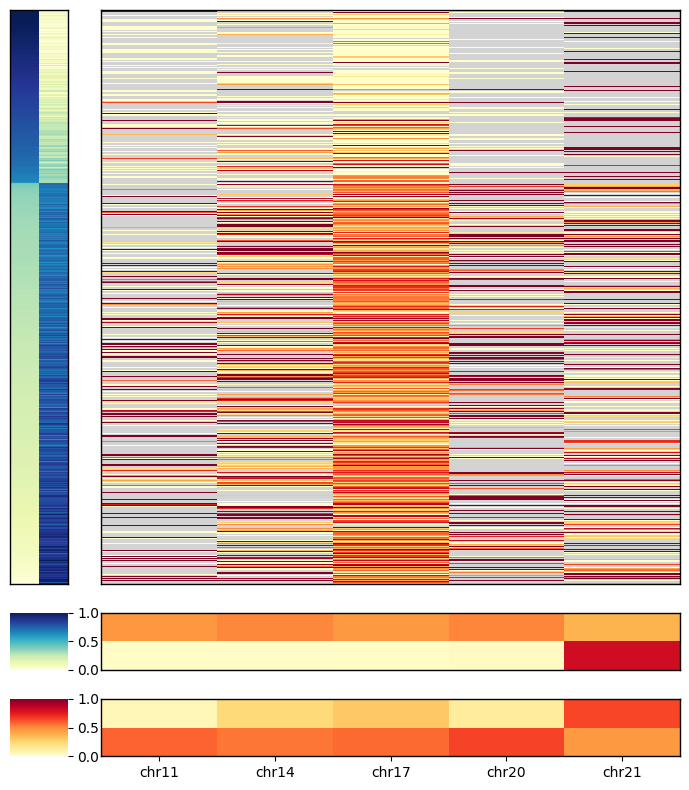

In [8]:
fig,((axs_0), (axs_1), (axs_2)) = plt.subplots(3,2,gridspec_kw={'height_ratios':[1,.1, .1],
                                                                      'width_ratios':[.1,1]}, figsize=(7,8))
args = {"yticklabels":[], "vmin":0, "vmax":1, "cbar_ax":axs_2[0], "cmap":var_cmap}

#################
# plot C matrix # 
#################
g = sns.heatmap(adata.obsm["C"], ax=axs_0[0], 
                cmap=cell_cmap,  xticklabels=[], yticklabels=[], vmin=0, vmax=1, cbar_ax=axs_1[0])
set_border(g)



###################################
# plot vars enriched in WE cancer # 
###################################
# get relevant variants
sub_vars = np.abs(np.diff(WE_VAF, axis=1)[:,0])>.3
sub_vars &= expressed
# plot VAF
g = sns.heatmap(VAF[:,sub_vars], ax=axs_0[1],  xticklabels=[], **args)
set_border(g)
# plot the variant weights
ylab = make_labels(adata[:,sub_vars])
g = sns.heatmap(V[sub_vars].T, ax=axs_2[1], xticklabels=ylab, **args)
set_border(g)
# plot the VAF in whole exome
g = sns.heatmap(WE_VAF[sub_vars].T, ax=axs_1[1], xticklabels=[], **args)
set_border(g)
    

#################
# show and save # 
#################
plt.tight_layout()
#save_path = "../figures/AML-S2_P1-WE-variants.pdf"
#fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)
plt.show()
plt.close()

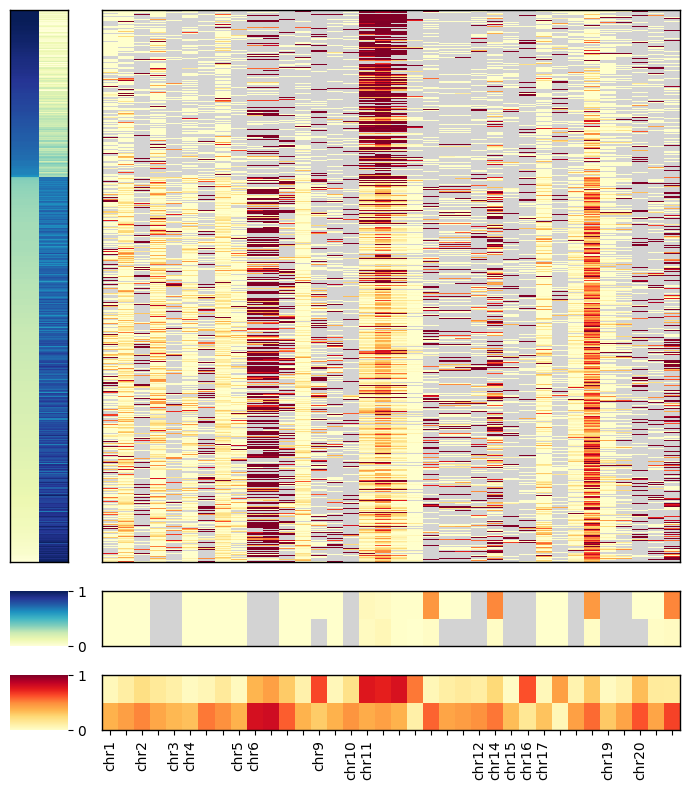

In [9]:
fig,((axs_0), (axs_1), (axs_2)) = plt.subplots(3,2,gridspec_kw={'height_ratios':[1,.1, .1],
                                                                      'width_ratios':[.1,1]}, figsize=(7,8))
args = {"yticklabels":[], "vmin":0, "vmax":1, "cbar_ax":axs_2[0], "cmap":var_cmap}

#################
# plot C matrix # 
#################
g = sns.heatmap(adata.obsm["C"], ax=axs_0[0], 
                cmap=cell_cmap,  xticklabels=[], yticklabels=[], vmin=0, vmax=1, cbar_ax=axs_1[0])
set_border(g)

###################################
# plot vars enriched in WE cancer # 
###################################
# get relevant variants
sub_vars = ((V[:,0]-V[:,1]>.3)|(V[:,1]-V[:,0]>.25)) #& (np.isnan(WE_VAF[:,1]))
sub_vars &= expressed
# plot VAF
g = sns.heatmap(VAF[:,sub_vars], 
                ax=axs_0[1],  xticklabels=[], **args)
set_border(g)
# plot the variant weights
ylab = make_labels(adata[:,sub_vars])
g = sns.heatmap(V[sub_vars].T, ax=axs_2[1], xticklabels=ylab, **args)
set_border(g)
# plot the VAF in whole exome
g = sns.heatmap(WE_VAF[sub_vars].T,
                ax=axs_1[1], xticklabels=[], **args)
set_border(g)
    

#################
# show and save # 
#################
plt.tight_layout()
save_path = "../figures/Fig3_P1-WE-variants.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)
plt.show()
plt.close()

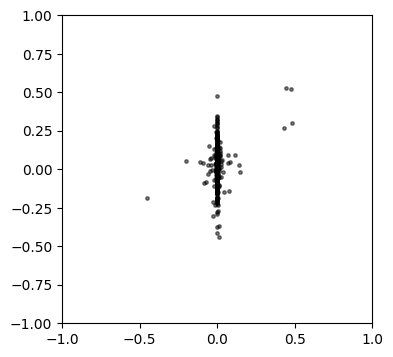

In [10]:
fig,ax = plt.subplots(1,1,figsize=(4,4))

#plt.scatter((WE_VAF[:,0]-WE_VAF[:,1])[~expressed], (V[:,0]-V[:,1])[~expressed], alpha=.5, color="grey", s=6)
plt.scatter((WE_VAF[:,0]-WE_VAF[:,1])[expressed], (V[:,1]-V[:,0])[expressed], alpha=.5, color="black", s=6)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
save_path = "../figures/S10_P1-weights.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)